In [7]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import random

In [8]:
# Function to load images from the folder
def load_images_from_folder(folder_path, max_depth=5):
    images = []
    labels = []
    names = []
    corruptedFiles = []
    image_extensions = ["bmp"]

    for root, dirs, files in os.walk(folder_path):
        current_depth = root[len(folder_path):].count(os.sep)

        # Skip folders with 'IriTech' or similar
        if ('IriTech' in root) or ('Iritech' in root) or ('iriTech' in root) or ('iritech' in root):
            continue

        if current_depth <= max_depth:
            for file in files:
                if any(file.lower().endswith(ext) for ext in image_extensions):
                    img_path = os.path.join(root, file)
                    try:
                        img = cv2.imread(img_path)
                        if img is not None:
                            # Resize image to 224x224x3 for EfficientNetV2
                            img = cv2.resize(img, image_size)
                            images.append(img)
                            # Binary label, '0' means Fit for Duty, others alcoholic
                            labels.append(file[6] != '0')
                            names.append(file)
                    except:
                        corruptedFiles.append(img_path)
        else:
            del dirs[:]

    print(f"Following {len(corruptedFiles)} files are corrupt or encountered error: \n {corruptedFiles}")
    return np.array(images), np.array(labels), np.array(names)


In [9]:
# Load dataset
images, labels, names = load_images_from_folder(dataset_path)
print(f"Read {len(images)} images from the data folder with shape {images.shape}")

# Preprocess data
images = np.array(images)
labels = np.array(labels)
images = images / 255.0  # Normalize images to [0, 1]
# Convert labels to categorical (one-hot encoding)
labels = to_categorical(labels, num_classes=2)

Following 0 files are corrupt or encountered error: 
 []
Read 2820 images from the data folder with shape (2820, 224, 224, 3)


In [10]:
# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

In [12]:
# Split the classes
alcoholicClass = [images[i] for i in range(len(labels)) if np.argmax(labels[i]) == 1]
nonAlcoholicClass = [images[i] for i in range(len(labels)) if np.argmax(labels[i]) == 0]

alcoholicClass = np.array(alcoholicClass)
nonAlcoholicClass = np.array(nonAlcoholicClass)


# Data Generator Setup
datagen = ImageDataGenerator(
    rotation_range=4,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.025,
    zoom_range=0.25,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Augmenting the non-alcoholic class to match the alcoholic class size
n1 = len(nonAlcoholicClass)
n2 = len(alcoholicClass)
target_size = n2
augmentation_needed = target_size - n1

print(f'Number of samples in Class 1 (FFD): {n1}')
print(f'Number of samples in Class 2 (Alcoholic): {n2}')
print(f'Augmenting {augmentation_needed} images for Class 1 to match Class 2.')

# Augmentation loop
augmented_images = []
for i in range(augmentation_needed):
    img = nonAlcoholicClass[i % n1]
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    augmented_img = next(datagen.flow(img, batch_size=1))[0]  # Generate augmented image
    augmented_images.append(augmented_img)

augmented_images = np.array(augmented_images)

# Concatenate augmented images with the non-alcoholic class
concagtedClassNon = np.concatenate([nonAlcoholicClass, augmented_images], axis=0)

print(f'New size of Class 1 (FFD): {len(concagtedClassNon)}')
print(f'New size of Class 2 (Alcoholic): {len(alcoholicClass)}')

# Combine the balanced data back into the dataset
X_train_balanced = np.concatenate([concagtedClassNon, alcoholicClass], axis=0)
y_train_balanced = np.concatenate([np.zeros(len(concagtedClassNon)), np.ones(len(alcoholicClass))], axis=0)
y_train_balanced = to_categorical(y_train_balanced, num_classes=2)

# Shuffle the data
indices = np.random.permutation(len(X_train_balanced))
X_train_balanced = X_train_balanced[indices]
y_train_balanced = y_train_balanced[indices]


Number of samples in Class 1 (FFD): 580
Number of samples in Class 2 (Alcoholic): 2240
Augmenting 1660 images for Class 1 to match Class 2.
New size of Class 1 (FFD): 2240
New size of Class 2 (Alcoholic): 2240


In [13]:
# Load pre-trained EfficientNetV2S model
base_model = EfficientNetV2S(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model

# Define the model
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [14]:
# Train the model
model.fit(X_train_balanced, y_train_balanced, epochs=10, validation_data=(X_test, y_test), verbose=1)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")


Epoch 1/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 268s 2s/step - accuracy: 0.5590 - loss: 0.6840 - val_accuracy: 0.6259 - val_loss: 0.6809
Epoch 2/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 244s 2s/step - accuracy: 0.6251 - loss: 0.6447 - val_accuracy: 0.7535 - val_loss: 0.5631
Epoch 3/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 239s 2s/step - accuracy: 0.6309 - loss: 0.6416 - val_accuracy: 0.6472 - val_loss: 0.6612
Epoch 4/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 242s 2s/step - accuracy: 0.6374 - loss: 0.6341 - val_accuracy: 0.7323 - val_loss: 0.5858
Epoch 5/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 241s 2s/step - accuracy: 0.6510 - loss: 0.6208 - val_accuracy: 0.5833 - val_loss: 0.7117
Epoch 6/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 241s 2s/step - accuracy: 0.6459 - loss: 0.6224 - val_accuracy: 0.7057 - val_loss: 0.6151
Epoch 7/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 234s 2s/step - accuracy: 0.6611 - loss: 0.6120 - val_accuracy: 0.7110 - val_loss: 0.6093
Epoch 8/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 223s 2s/step - accuracy: 0.6564 - loss: 0.6077 - val_accu

18/18 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step
Classification Report:
               precision    recall  f1-score   support

           0       0.25      0.30      0.27       115
           1       0.81      0.77      0.79       449

    accuracy                           0.67       564
   macro avg       0.53      0.53      0.53       564
weighted avg       0.69      0.67      0.68       564

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


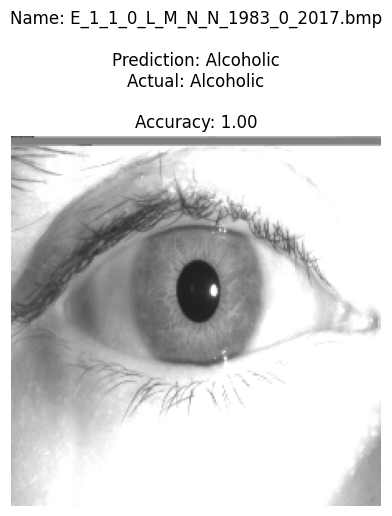

In [15]:
# Classification report
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)
print("Classification Report:\n", classification_report(y_test_classes, y_pred_classes))

# Initialize test counter
totalTest = 0
correctTest = 0

# Test on a random image from the test set
def test_random_image():
    global totalTest, correctTest

    # Select a random index from the test set
    random_index = random.randint(0, len(X_test) - 1)
    testImg = X_test[random_index]
    testLabel = y_test_classes[random_index]

    # Resize the image to the target size for the model
    testImg = cv2.resize(testImg, image_size)

    # Display the image
    plt.imshow(testImg)
    plt.axis('off')

    # Add batch dimension and normalize the image for prediction
    testImg = np.expand_dims(testImg, axis=0)

    # Predict the label for the image
    prediction = model.predict(testImg)
    prediction = np.argmax(prediction[0])

    # Update counters
    totalTest += 1
    correctTest += prediction == testLabel

    # Map prediction and test label to 'Alcoholic' or 'Fit for Duty'
    prediction = 'Alcoholic' if prediction == 1 else 'Fit for Duty'
    testLabel = 'Alcoholic' if testLabel == 1 else 'Fit for Duty'

    # Set the title with the name, prediction, and actual label
    plt.title(f'Name: {names[random_index]}\n\nPrediction: {prediction}\nActual: {testLabel}\n\nAccuracy: {correctTest / totalTest:.2f}')
    plt.show()

# Test on a random image from the test set
test_random_image()